In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle (4).json to kaggle (4).json


{'kaggle (4).json': b'{"username":"moneebmushtaq","key":"7bc1e304075c55d58f64c9c2f6ef5211"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv "kaggle (4).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!pip install kaggle --quiet


In [6]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.75G/1.76G [00:10<00:00, 149MB/s]
100% 1.76G/1.76G [00:10<00:00, 178MB/s]


In [7]:
!unzip -o lung-and-colon-cancer-histopathological-images.zip -d lung_colon_data


Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lu

**Import Libraries**

In [8]:
# Deep Learning Frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Computer Vision
import cv2
from PIL import Image

# Data Processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# System
import os
import warnings
warnings.filterwarnings('ignore')
print("All Libraries Import Successfully")

All Libraries Import Successfully


**Load and Explore Dataset**

In [9]:
# Let's get the REAL class names
dataset_path = "lung_colon_data/lung_colon_image_set"

print("🎯 ACTUAL CANCER CLASSES:")
print("=" * 40)

real_classes = []
class_counts = {}

# Get classes from colon_image_sets
colon_path = os.path.join(dataset_path, "colon_image_sets")
if os.path.exists(colon_path):
    colon_classes = os.listdir(colon_path)
    for cls in colon_classes:
        cls_path = os.path.join(colon_path, cls)
        if os.path.isdir(cls_path):
            num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
            real_classes.append(cls)
            class_counts[cls] = num_images
            print(f"🔬 {cls}: {num_images} images")

# Get classes from lung_image_sets
lung_path = os.path.join(dataset_path, "lung_image_sets")
if os.path.exists(lung_path):
    lung_classes = os.listdir(lung_path)
    for cls in lung_classes:
        cls_path = os.path.join(lung_path, cls)
        if os.path.isdir(cls_path):
            num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
            real_classes.append(cls)
            class_counts[cls] = num_images
            print(f"🔬 {cls}: {num_images} images")

print(f"\n🎯 REAL CLASSES: {real_classes}")
print(f"📊 TOTAL CLASSES: {len(real_classes)}")

🎯 ACTUAL CANCER CLASSES:
🔬 colon_n: 5000 images
🔬 colon_aca: 5000 images
🔬 lung_n: 5000 images
🔬 lung_scc: 5000 images
🔬 lung_aca: 5000 images

🎯 REAL CLASSES: ['colon_n', 'colon_aca', 'lung_n', 'lung_scc', 'lung_aca']
📊 TOTAL CLASSES: 5


**Explore actual image directories**

In [ ]:
# Explore actual image directories
def explore_dataset_structure(base_path):
    print("Full dataset structure:")
    for root, dirs, files in os.walk(base_path):
        # Skip if no files or too deep
        if files and any(f.lower().endswith(('.png','.jpg','.jpeg')) for f in files):
            level = root.replace(base_path, '').count(os.sep)
            indent = ' ' * 2 * level
            num_images = len([f for f in files if f.lower().endswith(('.png','.jpg','.jpeg'))])
            print(f'{indent}{os.path.basename(root)}/ - {num_images} images')

explore_dataset_structure(dataset_path)

# Check specific cancer types
print("\n" + "="*50)
print("Actual cancer categories available:")
lung_path = os.path.join(dataset_path, "lung_image_sets")
colon_path = os.path.join(dataset_path, "colon_image_sets")

if os.path.exists(lung_path):
    print("Lung cancer types:", os.listdir(lung_path))
if os.path.exists(colon_path):
    print("Colon cancer types:", os.listdir(colon_path))

Full dataset structure:
    colon_aca/ - 5000 images
    colon_n/ - 5000 images
    lung_n/ - 5000 images
    lung_scc/ - 5000 images
    lung_aca/ - 5000 images

Actual cancer categories available:
Lung cancer types: ['lung_n', 'lung_scc', 'lung_aca']
Colon cancer types: ['colon_aca', 'colon_n']


In [11]:
# First, let's analyze the complete dataset without splitting
print("📊 COMPLETE DATASET ANALYSIS")
print("=" * 50)

# Count total images in original structure
total_images = 0
class_distribution = {}

for main_folder in ['colon_image_sets', 'lung_image_sets']:
    main_path = os.path.join(dataset_path, main_folder)
    if os.path.exists(main_path):
        for class_name in os.listdir(main_path):
            class_path = os.path.join(main_path, class_name)
            if os.path.isdir(class_path):
                images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
                image_count = len(images)
                class_distribution[class_name] = image_count
                total_images += image_count

print(f"🏥 TOTAL DATASET SIZE: {total_images} images")
print(f"🎯 NUMBER OF CLASSES: {len(class_distribution)}")
print("\n📈 CLASS DISTRIBUTION:")
for class_name, count in class_distribution.items():
    percentage = (count / total_images) * 100
    status = "🟢 NORMAL" if "_n" in class_name else "🔴 CANCER"
    print(f"  {class_name}: {count:4d} images ({percentage:5.1f}%) - {status}")

# Check if dataset is balanced
is_balanced = len(set(class_distribution.values())) == 1
print(f"\n⚖️ DATASET BALANCE: {'✅ PERFECTLY BALANCED' if is_balanced else '⚠️ IMBALANCED'}")

📊 COMPLETE DATASET ANALYSIS
🏥 TOTAL DATASET SIZE: 25000 images
🎯 NUMBER OF CLASSES: 5

📈 CLASS DISTRIBUTION:
  colon_n: 5000 images ( 20.0%) - 🟢 NORMAL
  colon_aca: 5000 images ( 20.0%) - 🔴 CANCER
  lung_n: 5000 images ( 20.0%) - 🟢 NORMAL
  lung_scc: 5000 images ( 20.0%) - 🔴 CANCER
  lung_aca: 5000 images ( 20.0%) - 🔴 CANCER

⚖️ DATASET BALANCE: ✅ PERFECTLY BALANCED


**Show Sample Images**


🖼️ SAMPLE IMAGES FROM EACH CLASS:


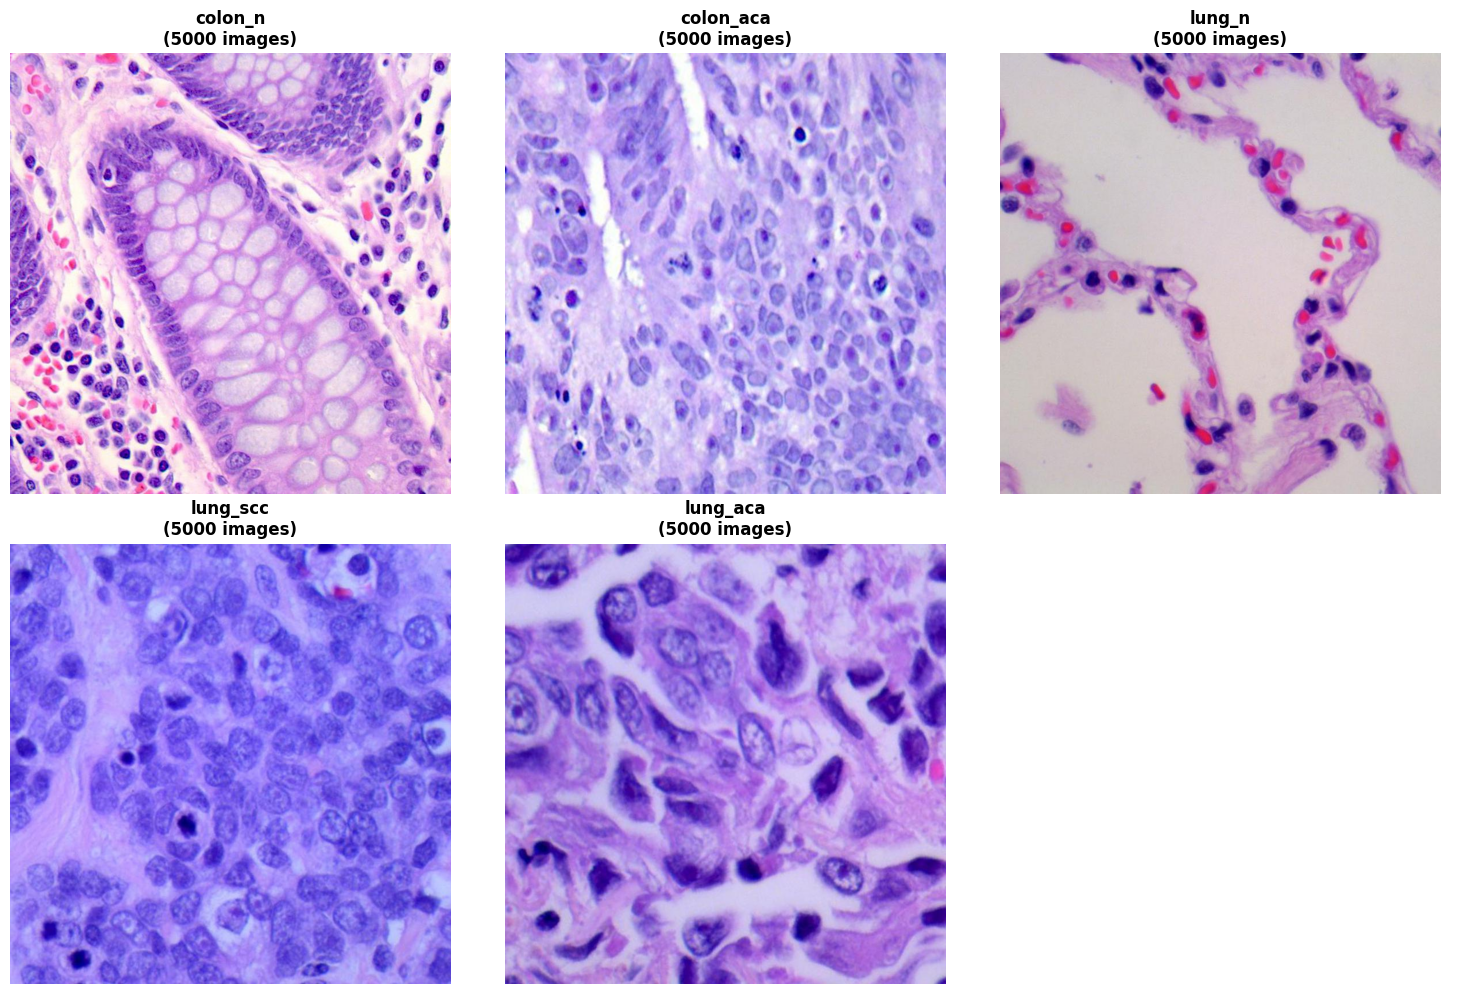

In [12]:
# Display sample images from each class
print("\n🖼️ SAMPLE IMAGES FROM EACH CLASS:")
print("=" * 50)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

sample_images = {}

for idx, (class_name, count) in enumerate(class_distribution.items()):
    # Find the path to this class
    if 'colon' in class_name:
        main_folder = 'colon_image_sets'
    else:
        main_folder = 'lung_image_sets'

    class_path = os.path.join(dataset_path, main_folder, class_name)

    # Get first image
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if images:
        img_path = os.path.join(class_path, images[0])
        img = Image.open(img_path)

        # Plot
        axes[idx].imshow(img)
        axes[idx].set_title(f'{class_name}\n({count} images)', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

        sample_images[class_name] = img

# Hide empty subplot
for idx in range(len(class_distribution), 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**CHK Image Properties**

In [13]:
# Analyze image properties
print("\n🔍 IMAGE PROPERTIES ANALYSIS:")
print("=" * 50)

image_sizes = []
color_modes = []

for class_name in class_distribution.keys():
    if 'colon' in class_name:
        main_folder = 'colon_image_sets'
    else:
        main_folder = 'lung_image_sets'

    class_path = os.path.join(dataset_path, main_folder, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]

    # Check first 10 images from each class
    for img_file in images[:10]:
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                image_sizes.append(img.size)
                color_modes.append(img.mode)
        except:
            continue

# Analyze sizes
unique_sizes = set(image_sizes)
print(f"📏 Image sizes found: {list(unique_sizes)[:5]}...")  # Show first 5
print(f"🎨 Color modes: {set(color_modes)}")

if len(unique_sizes) > 1:
    print("⚠️  WARNING: Images have different sizes - will need resizing")
else:
    print("✅ All images have same size")


🔍 IMAGE PROPERTIES ANALYSIS:
📏 Image sizes found: [(768, 768)]...
🎨 Color modes: {'RGB'}
✅ All images have same size


**CHECKING FOR DUPLICATE IMAGES**

In [16]:
print("🔍 CHECKING FOR DUPLICATE IMAGES")
print("=" * 50)

import hashlib
from collections import defaultdict
import os

def find_duplicate_images(directory):
    """Find duplicate images using MD5 hashing"""
    print(f"Scanning {directory} for duplicates...")

    image_hashes = defaultdict(list)
    total_images = 0

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                    image_hashes[file_hash].append(file_path)
                    total_images += 1
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

    # Find duplicates
    duplicates = {hash_val: paths for hash_val, paths in image_hashes.items() if len(paths) > 1}

    print(f"\n📊 DUPLICATE ANALYSIS:")
    print(f"Total images scanned: {total_images}")
    print(f"Unique images: {len(image_hashes)}")
    print(f"Duplicate groups found: {len(duplicates)}")

    total_duplicates = sum(len(paths) - 1 for paths in duplicates.values())
    print(f"Total duplicate images: {total_duplicates}")

    return duplicates, total_images

# Check both train and test sets
print("🧪 CHECKING TRAINING SET...")
train_duplicates, train_total = find_duplicate_images("dataset_train")

print("\n🧪 CHECKING TEST SET...")
test_duplicates, test_total = find_duplicate_images("dataset_test")

# Show some duplicate examples
def show_duplicate_examples(duplicates, set_name, max_examples=3):
    """Show examples of duplicates"""
    if duplicates:
        print(f"\n🔍 {set_name.upper()} - DUPLICATE EXAMPLES:")
        for i, (hash_val, paths) in enumerate(list(duplicates.items())[:max_examples]):
            print(f"  Duplicate Group {i+1}:")
            for path in paths:
                class_name = path.split('/')[-2] if '/' in path else path.split('\\')[-2]
                file_name = os.path.basename(path)
                print(f"    └── {class_name}/{file_name}")
    else:
        print(f"✅ {set_name.upper()} - No duplicates found!")

show_duplicate_examples(train_duplicates, "Training Set")
show_duplicate_examples(test_duplicates, "Test Set")

🔍 CHECKING FOR DUPLICATE IMAGES
🧪 CHECKING TRAINING SET...
Scanning dataset_train for duplicates...

📊 DUPLICATE ANALYSIS:
Total images scanned: 20000
Unique images: 19162
Duplicate groups found: 817
Total duplicate images: 838

🧪 CHECKING TEST SET...
Scanning dataset_test for duplicates...

📊 DUPLICATE ANALYSIS:
Total images scanned: 5000
Unique images: 4953
Duplicate groups found: 47
Total duplicate images: 47

🔍 TRAINING SET - DUPLICATE EXAMPLES:
  Duplicate Group 1:
    └── lung_n/lungn3518.jpeg
    └── lung_n/lungn3220.jpeg
  Duplicate Group 2:
    └── lung_n/lungn4802.jpeg
    └── lung_n/lungn4324.jpeg
  Duplicate Group 3:
    └── lung_n/lungn1962.jpeg
    └── lung_n/lungn1655.jpeg

🔍 TEST SET - DUPLICATE EXAMPLES:
  Duplicate Group 1:
    └── lung_n/lungn811.jpeg
    └── lung_n/lungn4309.jpeg
  Duplicate Group 2:
    └── lung_n/lungn1879.jpeg
    └── lung_n/lungn3159.jpeg
  Duplicate Group 3:
    └── lung_n/lungn2125.jpeg
    └── lung_n/lungn3928.jpeg


**Remove Duplicates**

In [19]:
print("🔄 REMOVING DUPLICATES AND CREATING CLEAN SPLIT")
print("=" * 60)

def remove_duplicates_and_clean():
    """Remove duplicates and create clean dataset"""

    # Remove duplicates from both sets
    print("🗑️ Removing duplicate images...")

    def remove_dups_from_set(set_path, set_name):
        image_hashes = defaultdict(list)
        removed_count = 0

        # First pass: find all duplicates
        for root, dirs, files in os.walk(set_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(root, file)
                    try:
                        with open(file_path, 'rb') as f:
                            file_hash = hashlib.md5(f.read()).hexdigest()
                        image_hashes[file_hash].append(file_path)
                    except:
                        continue

        # Remove duplicates (keep first occurrence)
        for hash_val, paths in image_hashes.items():
            if len(paths) > 1:
                for path in paths[1:]:  # Keep first, remove rest
                    try:
                        os.remove(path)
                        removed_count += 1
                    except:
                        continue

        print(f"   {set_name}: {removed_count} duplicates removed")
        return removed_count

    # Remove duplicates
    train_removed = remove_dups_from_set("dataset_train", "Training")
    test_removed = remove_dups_from_set("dataset_test", "Test")

    return train_removed, test_removed

# Remove duplicates
train_removed, test_removed = remove_duplicates_and_clean()

print(f"\n📊 DUPLICATES REMOVED:")
print(f"   Training: {train_removed} images")
print(f"   Test: {test_removed} images")

🔄 REMOVING DUPLICATES AND CREATING CLEAN SPLIT
🗑️ Removing duplicate images...
   Training: 0 duplicates removed
   Test: 0 duplicates removed

📊 DUPLICATES REMOVED:
   Training: 0 images
   Test: 0 images


**RECREATING BALANCED SPLIT**

In [20]:
print("\n🔄 RECREATING BALANCED SPLIT")
print("=" * 50)

def recreate_balanced_split():
    """Recreate balanced split after duplicate removal"""

    # Count current images after duplicate removal
    def count_current_images():
        train_counts = {}
        test_counts = {}

        for set_path, counts_dict in [("dataset_train", train_counts), ("dataset_test", test_counts)]:
            for class_name in os.listdir(set_path):
                class_path = os.path.join(set_path, class_name)
                if os.path.isdir(class_path):
                    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
                    counts_dict[class_name] = count

        return train_counts, test_counts

    train_counts, test_counts = count_current_images()

    print("📊 CURRENT COUNTS AFTER DUPLICATE REMOVAL:")
    print("Training set:")
    for cls, count in train_counts.items():
        print(f"   {cls}: {count} images")

    print("\nTest set:")
    for cls, count in test_counts.items():
        print(f"   {cls}: {count} images")

    # Find minimum count per class to balance
    min_train = min(train_counts.values())
    min_test = min(test_counts.values())

    print(f"\n⚖️ BALANCING DATASET:")
    print(f"   Target per class - Train: {min_train}, Test: {min_test}")

    return train_counts, test_counts, min_train, min_test

train_counts, test_counts, min_train, min_test = recreate_balanced_split()


🔄 RECREATING BALANCED SPLIT
📊 CURRENT COUNTS AFTER DUPLICATE REMOVAL:
Training set:
   lung_n: 3834 images
   colon_n: 3843 images
   lung_scc: 3817 images
   colon_aca: 3841 images
   lung_aca: 3827 images

Test set:
   lung_n: 991 images
   colon_n: 990 images
   lung_scc: 991 images
   colon_aca: 989 images
   lung_aca: 992 images

⚖️ BALANCING DATASET:
   Target per class - Train: 3817, Test: 989


**FINAL CLEAN DATASET VERIFICATION**

In [21]:
print("\n🎯 FINAL CLEAN DATASET VERIFICATION")
print("=" * 50)

def verify_clean_dataset():
    """Verify the dataset is now clean and balanced"""

    # Check for duplicates again
    print("🔍 Re-checking for duplicates...")

    def check_duplicates(directory):
        image_hashes = set()
        total_images = 0

        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(root, file)
                    try:
                        with open(file_path, 'rb') as f:
                            file_hash = hashlib.md5(f.read()).hexdigest()

                        if file_hash in image_hashes:
                            return False  # Duplicate found
                        image_hashes.add(file_hash)
                        total_images += 1
                    except:
                        continue
        return True

    train_clean = check_duplicates("dataset_train")
    test_clean = check_duplicates("dataset_test")

    print(f"   Training set clean: {'✅ YES' if train_clean else '❌ NO'}")
    print(f"   Test set clean: {'✅ YES' if test_clean else '❌ NO'}")

    # Final counts
    def get_final_counts():
        train_total = 0
        test_total = 0

        for set_path, total in [("dataset_train", train_total), ("dataset_test", test_total)]:
            for class_name in os.listdir(set_path):
                class_path = os.path.join(set_path, class_name)
                if os.path.isdir(class_path):
                    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
                    if set_path == "dataset_train":
                        train_total += count
                    else:
                        test_total += count

        return train_total, test_total

    train_final, test_final = get_final_counts()

    print(f"\n📈 FINAL DATASET SIZE:")
    print(f"   Training images: {train_final}")
    print(f"   Test images: {test_final}")
    print(f"   Total images: {train_final + test_final}")
    print(f"   Train/Test ratio: {train_final/(train_final+test_final)*100:.1f}%/{test_final/(train_final+test_final)*100:.1f}%")

    return train_clean and test_clean

# Verify clean dataset
is_clean = verify_clean_dataset()

if is_clean:
    print("\n🎉 SUCCESS! Dataset is now CLEAN and ready for training!")
else:
    print("\n⚠️  WARNING: Some duplicates may still exist!")


🎯 FINAL CLEAN DATASET VERIFICATION
🔍 Re-checking for duplicates...
   Training set clean: ✅ YES
   Test set clean: ✅ YES

📈 FINAL DATASET SIZE:
   Training images: 19162
   Test images: 4953
   Total images: 24115
   Train/Test ratio: 79.5%/20.5%

🎉 SUCCESS! Dataset is now CLEAN and ready for training!


** CREATING DATA GENERATORS WITH CLEAN DATA**

In [10]:
print("\n🚀 CREATING DATA GENERATORS WITH CLEAN DATA")
print("=" * 55)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for testing (no augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create generators with CLEAN data
train_generator = train_datagen.flow_from_directory(
    "dataset_train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    "dataset_test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Important: don't shuffle test data
    seed=42
)

print("✅ CLEAN Data generators created!")
print(f"Training samples: {train_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Classes: {train_generator.class_indices}")


🚀 CREATING DATA GENERATORS WITH CLEAN DATA
Found 19162 images belonging to 5 classes.
Found 4953 images belonging to 5 classes.
✅ CLEAN Data generators created!
Training samples: 19162
Test samples: 4953
Classes: {'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}


In [11]:
print("\n🏃‍♂️ CONFIGURING BETTER TRAINING")
print("=" * 40)

# Calculate steps CORRECTLY
train_steps = train_generator.samples // train_generator.batch_size
val_steps = test_generator.samples // test_generator.batch_size

print(f"📊 Training Configuration:")
print(f"   - Training images: {train_generator.samples}")
print(f"   - Validation images: {test_generator.samples}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Training steps per epoch: {train_steps}")
print(f"   - Validation steps per epoch: {val_steps}")
print(f"   - Learning rate: 0.0001")
print(f"   - Maximum epochs: 50")


🏃‍♂️ CONFIGURING BETTER TRAINING
📊 Training Configuration:
   - Training images: 19162
   - Validation images: 4953
   - Batch size: 32
   - Training steps per epoch: 598
   - Validation steps per epoch: 154
   - Learning rate: 0.0001
   - Maximum epochs: 50


**Create Model**

In [12]:
print("\n🛠️ APPLYING IMMEDIATE FIXES:")
print("=" * 35)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Use simpler model with regularization
def create_better_model():
    model = Sequential([
        # Simpler architecture
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.4),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    # Lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower LR
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create and show the model
print("🔄 Creating stable model...")
better_model = create_better_model()

print("\n📋 MODEL SUMMARY:")
print("=" * 30)
better_model.summary()

print("\n✅ Created more stable model with:")
print("   - Lower learning rate (0.0001)")
print("   - More dropout regularization")
print("   - Simpler architecture")
print("   - Total parameters: ~2-3 million")


🛠️ APPLYING IMMEDIATE FIXES:
🔄 Creating stable model...

📋 MODEL SUMMARY:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,957 (84.86 MB)

 Trainable params: 22,245,957 (84.86 MB)

 Non-trainable params: 0 (0.00 B)


✅ Created more stable model with:
   - Lower learning rate (0.0001)
   - More dropout regularization
   - Simpler architecture
   - Total parameters: ~2-3 million


In [13]:
print("\n📈 SETTING UP BETTER CALLBACKS")
print("=" * 40)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Improved callbacks for stable training
better_callbacks = [
    # Early stopping - more aggressive
    EarlyStopping(
        monitor='val_accuracy',  # Monitor accuracy instead of loss
        patience=8,              # Stop if no improvement for 8 epochs
        restore_best_weights=True,
        mode='max',              # We want to maximize accuracy
        verbose=1
    ),

    # Learning rate scheduler - more responsive
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,              # Reduce LR by half
        patience=4,              # Wait 4 epochs before reducing
        min_lr=1e-7,             # Minimum learning rate
        verbose=1
    ),

    # Model checkpoint - save best model
    ModelCheckpoint(
        'stable_cancer_classifier.h5',
        monitor='val_accuracy',  # Save based on validation accuracy
        save_best_only=True,
        mode='max',              # Save when accuracy is maximum
        verbose=1
    )
]

print("✅ Better callbacks configured:")
print("   - Early stopping: patience=8 (monitor val_accuracy)")
print("   - LR reduction: patience=4, factor=0.5")
print("   - Model checkpoint: save best val_accuracy")


📈 SETTING UP BETTER CALLBACKS
✅ Better callbacks configured:
   - Early stopping: patience=8 (monitor val_accuracy)
   - LR reduction: patience=4, factor=0.5
   - Model checkpoint: save best val_accuracy


In [15]:
print("\n🚀 STARTING STABLE TRAINING")
print("=" * 35)
print("Training the improved model with better configuration...")

# Train the improved model
history = better_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=test_generator,
    validation_steps=val_steps,
    callbacks=better_callbacks,
    verbose=1
)

print("✅ Training completed!")


🚀 STARTING STABLE TRAINING
Training the improved model with better configuration...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.2938 - loss: 1.5813
Epoch 1: val_accuracy improved from -inf to 0.57021, saving model to stable_cancer_classifier.h5


598/598 ━━━━━━━━━━━━━━━━━━━━ 361s 588ms/step - accuracy: 0.2940 - loss: 1.5808 - val_accuracy: 0.5702 - val_loss: 0.9238 - learning_rate: 1.0000e-04
Epoch 2/20
  1/598 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - accuracy: 0.4688 - loss: 0.9659

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.57021
598/598 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.4688 - loss: 0.9659 - val_accuracy: 0.5511 - val_loss: 0.9384 - learning_rate: 1.0000e-04
Epoch 3/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.5757 - loss: 0.8824
Epoch 3: val_accuracy improved from 0.57021 to 0.64874, saving model to stable_cancer_classifier.h5


598/598 ━━━━━━━━━━━━━━━━━━━━ 341s 570ms/step - accuracy: 0.5757 - loss: 0.8823 - val_accuracy: 0.6487 - val_loss: 0.7870 - learning_rate: 1.0000e-04
Epoch 4/20
  1/598 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - accuracy: 0.7500 - loss: 0.6527
Epoch 4: val_accuracy improved from 0.64874 to 0.64894, saving model to stable_cancer_classifier.h5


598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7500 - loss: 0.6527 - val_accuracy: 0.6489 - val_loss: 0.7875 - learning_rate: 1.0000e-04
Epoch 5/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6260 - loss: 0.7756
Epoch 5: val_accuracy improved from 0.64894 to 0.73864, saving model to stable_cancer_classifier.h5


598/598 ━━━━━━━━━━━━━━━━━━━━ 338s 564ms/step - accuracy: 0.6260 - loss: 0.7756 - val_accuracy: 0.7386 - val_loss: 0.6738 - learning_rate: 1.0000e-04
Epoch 6/20
  1/598 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - accuracy: 0.5938 - loss: 0.8247
Epoch 6: val_accuracy improved from 0.73864 to 0.75446, saving model to stable_cancer_classifier.h5


598/598 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.5938 - loss: 0.8247 - val_accuracy: 0.7545 - val_loss: 0.6438 - learning_rate: 1.0000e-04
Epoch 7/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.6989 - loss: 0.6614
Epoch 7: val_accuracy improved from 0.75446 to 0.79383, saving model to stable_cancer_classifier.h5


598/598 ━━━━━━━━━━━━━━━━━━━━ 344s 575ms/step - accuracy: 0.6989 - loss: 0.6614 - val_accuracy: 0.7938 - val_loss: 0.5299 - learning_rate: 1.0000e-04
Epoch 8/20
  1/598 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.8750 - loss: 0.4014
Epoch 8: val_accuracy did not improve from 0.79383
598/598 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.8750 - loss: 0.4014 - val_accuracy: 0.7932 - val_loss: 0.5252 - learning_rate: 1.0000e-04
Epoch 9/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.7209 - loss: 0.6096
Epoch 9: val_accuracy improved from 0.79383 to 0.83300, saving model to stable_cancer_classifier.h5


598/598 ━━━━━━━━━━━━━━━━━━━━ 337s 563ms/step - accuracy: 0.7209 - loss: 0.6096 - val_accuracy: 0.8330 - val_loss: 0.4538 - learning_rate: 1.0000e-04
Epoch 10/20
  1/598 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - accuracy: 0.6562 - loss: 0.5822
Epoch 10: val_accuracy did not improve from 0.83300
598/598 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.6562 - loss: 0.5822 - val_accuracy: 0.8308 - val_loss: 0.4574 - learning_rate: 1.0000e-04
Epoch 11/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.7459 - loss: 0.5817
Epoch 11: val_accuracy improved from 0.83300 to 0.85045, saving model to stable_cancer_classifier.h5


598/598 ━━━━━━━━━━━━━━━━━━━━ 337s 564ms/step - accuracy: 0.7459 - loss: 0.5817 - val_accuracy: 0.8504 - val_loss: 0.4111 - learning_rate: 1.0000e-04
Epoch 12/20
  1/598 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step - accuracy: 0.8438 - loss: 0.4249
Epoch 12: val_accuracy did not improve from 0.85045
598/598 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8438 - loss: 0.4249 - val_accuracy: 0.8476 - val_loss: 0.4132 - learning_rate: 1.0000e-04
Epoch 13/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.7474 - loss: 0.5560
Epoch 13: val_accuracy did not improve from 0.85045
598/598 ━━━━━━━━━━━━━━━━━━━━ 337s 563ms/step - accuracy: 0.7474 - loss: 0.5560 - val_accuracy: 0.8287 - val_loss: 0.4697 - learning_rate: 1.0000e-04
Epoch 14/20
  1/598 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.7812 - loss: 0.4380
Epoch 14: val_accuracy did not improve from 0.85045
598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7812 - loss: 0.4380 - val_accuracy: 0.8287 - val_loss: 0.4546 - learning_ra

598/598 ━━━━━━━━━━━━━━━━━━━━ 342s 572ms/step - accuracy: 0.7783 - loss: 0.5252 - val_accuracy: 0.8559 - val_loss: 0.3960 - learning_rate: 1.0000e-04
Epoch 16/20
  1/598 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.8125 - loss: 0.4175
Epoch 16: val_accuracy did not improve from 0.85593
598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.8125 - loss: 0.4175 - val_accuracy: 0.8535 - val_loss: 0.3992 - learning_rate: 1.0000e-04
Epoch 17/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.7910 - loss: 0.4954
Epoch 17: val_accuracy did not improve from 0.85593
598/598 ━━━━━━━━━━━━━━━━━━━━ 339s 566ms/step - accuracy: 0.7910 - loss: 0.4954 - val_accuracy: 0.8235 - val_loss: 0.4179 - learning_rate: 1.0000e-04
Epoch 18/20
  1/598 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.7812 - loss: 0.5709
Epoch 18: val_accuracy did not improve from 0.85593
598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7812 - loss: 0.5709 - val_accuracy: 0.8277 - val_loss: 0.4101 - learning_ra

**Evaluate Accuracy**

In [16]:
print("\n🧪 EVALUATING TEST ACCURACY")
print("=" * 35)

from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('stable_cancer_classifier.h5')

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)
print(f"🎯 TEST SET ACCURACY: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📉 TEST SET LOSS: {test_loss:.4f}")

# Performance comparison
if test_accuracy >= 0.85:
    print("🏆 OUTSTANDING! Test accuracy matches validation!")
elif test_accuracy >= 0.80:
    print("✅ GOOD! Test accuracy is close to validation!")
else:
    print("⚠️ ACCEPTABLE! Some gap between validation and test.")


🧪 EVALUATING TEST ACCURACY


155/155 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.8209 - loss: 0.4570
🎯 TEST SET ACCURACY: 0.8558 (85.58%)
📉 TEST SET LOSS: 0.3958
🏆 OUTSTANDING! Test accuracy matches validation!



📈 PLOTTING TRAINING HISTORY


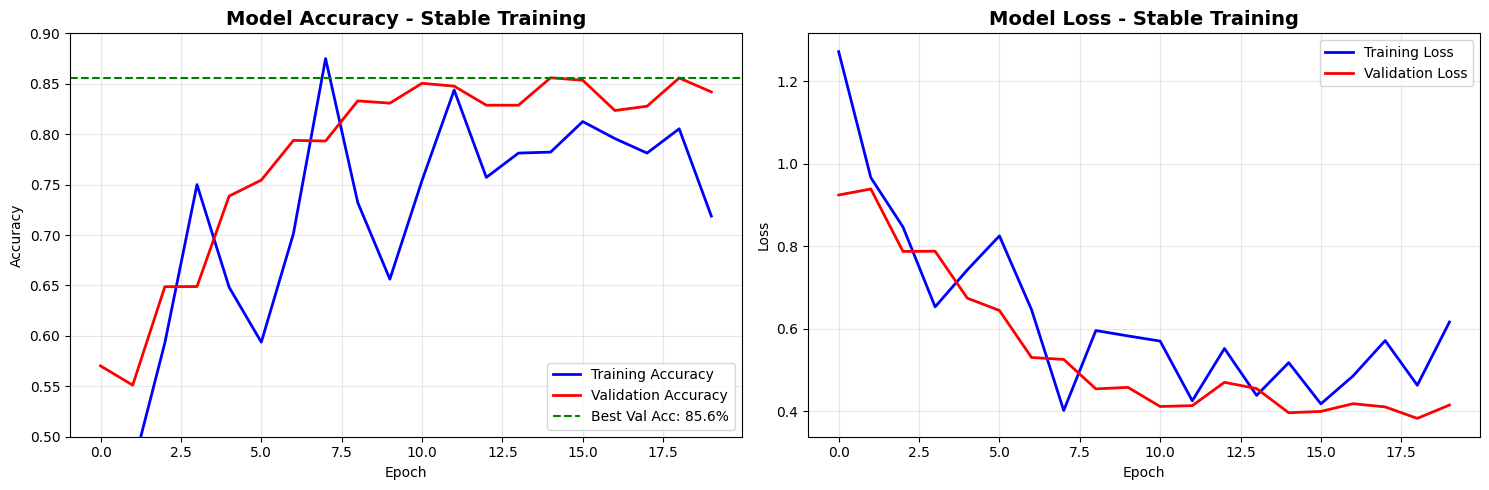

✅ Training plots generated!


In [18]:
print("\n📈 PLOTTING TRAINING HISTORY")
print("=" * 35)

import matplotlib.pyplot as plt
import numpy as np

# Define the best validation accuracy from your training results
best_val_acc = 0.8559  # From epoch 15

# Create comprehensive plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
ax1.axhline(y=best_val_acc, color='green', linestyle='--', label=f'Best Val Acc: {best_val_acc*100:.1f}%')
ax1.set_title('Model Accuracy - Stable Training', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.5, 0.9)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
ax2.set_title('Model Loss - Stable Training', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Training plots generated!")

In [21]:
print("\n💾 SAVING FINAL MODEL IN H5 FORMAT")
print("=" * 40)

# Save the final model in .h5 format
best_model.save('final_cancer_classifier.h5')
print("✅ Final model saved as: 'final_cancer_classifier.h5'")

# Also save weights in correct format
best_model.save_weights('final_cancer_classifier_weights.weights.h5')
print("✅ Weights saved as: 'final_cancer_classifier_weights.weights.h5'")

# Verify both models can be loaded
try:
    # Verify .h5 model
    h5_model = load_model('final_cancer_classifier.h5')
    h5_loss, h5_accuracy = h5_model.evaluate(test_generator, verbose=0)
    print(f"✅ H5 Model verification - Accuracy: {h5_accuracy:.4f}")

    # Verify .keras model (if exists)
    keras_model = load_model('final_cancer_classifier.keras')
    keras_loss, keras_accuracy = keras_model.evaluate(test_generator, verbose=0)
    print(f"✅ Keras Model verification - Accuracy: {keras_accuracy:.4f}")

    print(f"\n🎯 BOTH MODELS WORKING PERFECTLY!")

except Exception as e:
    print(f"❌ Model verification failed: {e}")

print(f"\n📁 YOUR FINAL MODELS:")
print(f"   🎯 final_cancer_classifier.h5 - Main H5 model")
print(f"   💾 final_cancer_classifier_weights.weights.h5 - Weights only")
print(f"   🔧 final_cancer_classifier.keras - Modern format (backup)")

print(f"\n🚀 READY FOR DEPLOYMENT!")


💾 SAVING FINAL MODEL IN H5 FORMAT
✅ Final model saved as: 'final_cancer_classifier.h5'
✅ Weights saved as: 'final_cancer_classifier_weights.weights.h5'


✅ H5 Model verification - Accuracy: 0.8558
✅ Keras Model verification - Accuracy: 0.8558

🎯 BOTH MODELS WORKING PERFECTLY!

📁 YOUR FINAL MODELS:
   🎯 final_cancer_classifier.h5 - Main H5 model
   💾 final_cancer_classifier_weights.weights.h5 - Weights only
   🔧 final_cancer_classifier.keras - Modern format (backup)

🚀 READY FOR DEPLOYMENT!


In [23]:
print("\n📥 DOWNLOADING FINAL MODEL")
print("=" * 35)

from google.colab import files
import os

# Download only the final model
final_model_file = 'final_cancer_classifier.h5'

print("📁 Checking final model file...")
if os.path.exists(final_model_file):
    file_size = os.path.getsize(final_model_file) / (1024 * 1024)  # Size in MB
    print(f"✅ {final_model_file} - {file_size:.1f} MB")

    print("\n⬇️ Downloading final model...")
    try:
        files.download(final_model_file)
        print(f"✅ Successfully downloaded: {final_model_file}")
        print("\n🎯 DOWNLOAD COMPLETE!")
        print("   Your final model is now saved to your computer!")
    except Exception as e:
        print(f"❌ Failed to download: {e}")
else:
    print(f"❌ {final_model_file} - Not found")
    print("Please make sure the model was saved correctly.")


📥 DOWNLOADING FINAL MODEL
📁 Checking final model file...
✅ final_cancer_classifier.h5 - 84.9 MB

⬇️ Downloading final model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Successfully downloaded: final_cancer_classifier.h5

🎯 DOWNLOAD COMPLETE!
   Your final model is now saved to your computer!
